# Experiment 0: Width vs Depth Grid Analysis (CIFAR10)

## Experiment Goal
Understand how **width** and **depth** scaling affect model capacity and robustness in federated learning under poisoning attacks.

## Research Questions
1. How does model width vs depth affect test accuracy?
2. Which scaling dimension (width vs depth) provides better robustness against poisoning?
3. What is the optimal width-to-depth ratio for robustness?
4. How does parameter count relate to model performance?

## 1. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 2. Data Loading

In [2]:
RESULT_FILE = "./results_exp0_cifar10/final_results.csv"
OUTPUT_DIR = "./results_exp0_cifar10/plots"

# Create output directory if it doesn't exist
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
try:
    df = pd.read_csv(RESULT_FILE)
    print(f"✓ Data loaded successfully: {len(df)} rows")
    df.head()
except FileNotFoundError:
    print(f"❌ Error: File {RESULT_FILE} not found.")
    print("Please run the experiment first to generate results.")

✓ Data loaded successfully: 48 rows


## 3. Data Overview

In [3]:
# Data shape and info
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (48, 20)

Columns: ['phase', 'dataset', 'width_factor', 'depth', 'poison_ratio', 'alpha', 'data_ordering', 'aggregator', 'batch_size', 'mean_test_acc', 'std_test_acc', 'mean_test_loss', 'std_test_loss', 'mean_val_acc', 'std_val_acc', 'mean_val_loss', 'std_val_loss', 'num_parameters', 'best_epoch', 'raw_seeds']

Data Types:
phase              object
dataset            object
width_factor        int64
depth               int64
poison_ratio      float64
alpha             float64
data_ordering      object
aggregator         object
batch_size          int64
mean_test_acc     float64
std_test_acc      float64
mean_test_loss    float64
std_test_loss     float64
mean_val_acc      float64
std_val_acc       float64
mean_val_loss     float64
std_val_loss      float64
num_parameters    float64
best_epoch          int64
raw_seeds          object
dtype: object

Missing Values:
phase             0
dataset           0
width_factor      0
depth             0
poison_ratio      0
alpha    

In [4]:
# Statistical Summary
df.describe()

,width_factor,depth,poison_ratio,alpha,batch_size,mean_test_acc,std_test_acc,mean_test_loss,std_test_loss,mean_val_acc,std_val_acc,mean_val_loss,std_val_loss,num_parameters,best_epoch
count,48.000000,48.000000,48.000000,48.0,48.0,48.000000,4.800000e+01,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,4.800000e+01,48.000000
mean,21.250000,21.250000,0.266667,100.0,128.0,0.432488,1.136113e-02,1.564000,0.025758,0.439403,0.011024,1.588099,0.032694,2.589072e+05,46.687500
std,25.579663,25.579663,0.207655,0.0,0.0,0.242708,1.471350e-02,0.554928,0.042453,0.243278,0.015055,0.554928,0.043916,5.766608e+05,44.916071
min,1.000000,1.000000,0.000000,100.0,128.0,0.099200,1.387779e-17,0.736153,0.000213,0.096400,0.000000,0.750041,0.001048,2.300000e+02,0.000000
25%,3.250000,3.250000,0.000000,100.0,128.0,0.126408,2.162190e-03,1.124535,0.003674,0.134233,0.002858,1.140338,0.007790,2.996000e+03,19.000000
50%,10.000000,10.000000,0.300000,100.0,128.0,0.500467,7.987759e-03,1.445418,0.014384,0.510733,0.006169,1.548906,0.013664,2.685800e+04,29.500000
75%,28.000000,28.000000,0.500000,100.0,128.0,0.631158,1.283544e-02,2.220298,0.022999,0.640133,0.012131,2.229217,0.037050,1.566260e+05,56.000000
max,64.000000,64.000000,0.500000,100.0,128.0,0.752333,7.081550e-02,2.320681,0.174489,0.764133,0.067722,2.329030,0.170753,2.337098e+06,214.000000


In [5]:
# Unique values for key parameters
print("Unique Width Factors:", sorted(df['width_factor'].unique()))
print("Unique Depths:", sorted(df['depth'].unique()))
print("Unique Poison Ratios:", sorted(df['poison_ratio'].unique()))
print("Unique Aggregators:", df['aggregator'].unique())

Unique Width Factors: [np.int64(1), np.int64(4), np.int64(16), np.int64(64)]
Unique Depths: [np.int64(1), np.int64(4), np.int64(16), np.int64(64)]
Unique Poison Ratios: [np.float64(0.0), np.float64(0.3), np.float64(0.5)]
Unique Aggregators: ['fedavg']


## 4. Visualizations

### 4.1 Heatmap: Width vs Depth (Clean Data)

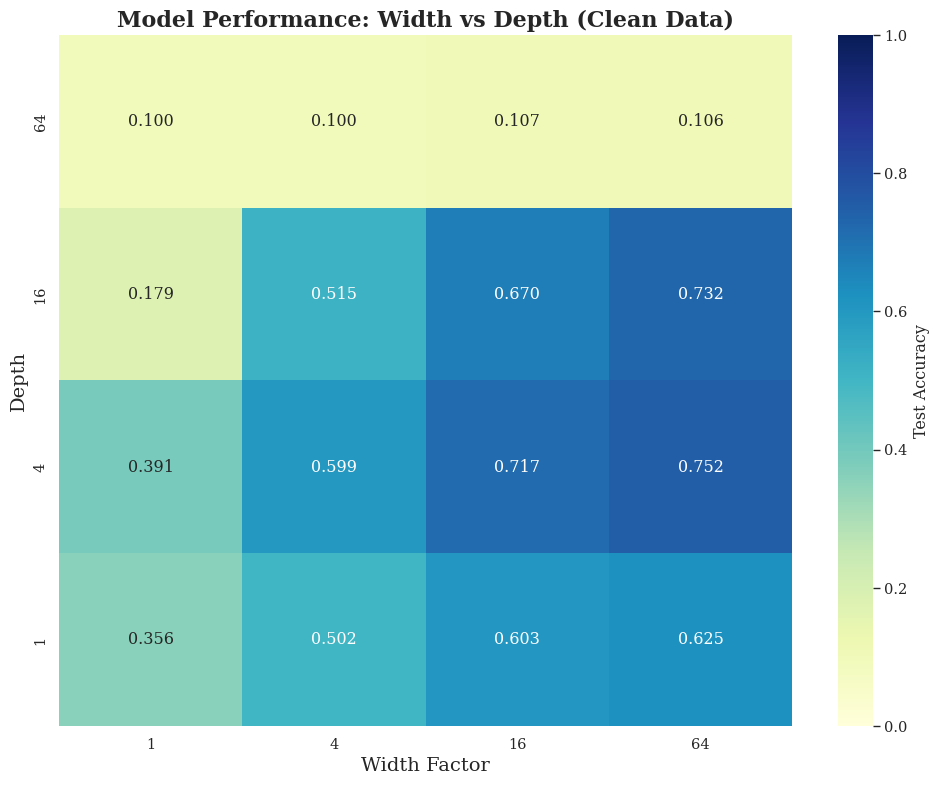

In [24]:
# Filter clean data (no poisoning)
clean_data = df[df['poison_ratio'] == 0.0].copy()

# Create pivot table
pivot_clean = clean_data.pivot_table(
    values='mean_test_acc', 
    index='depth', 
    columns='width_factor',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_clean, annot=True, fmt='.3f', cmap='YlGnBu', 
            cbar_kws={'label': 'Test Accuracy'}, vmin=0.0, vmax=1.0)
plt.title('Model Performance: Width vs Depth (Clean Data)', fontsize=16, weight='bold')
plt.xlabel('Width Factor', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/heatmap_width_vs_depth_clean.png")
plt.show()

### 4.2 Heatmap: Width vs Depth (Poisoned Data - 50%)

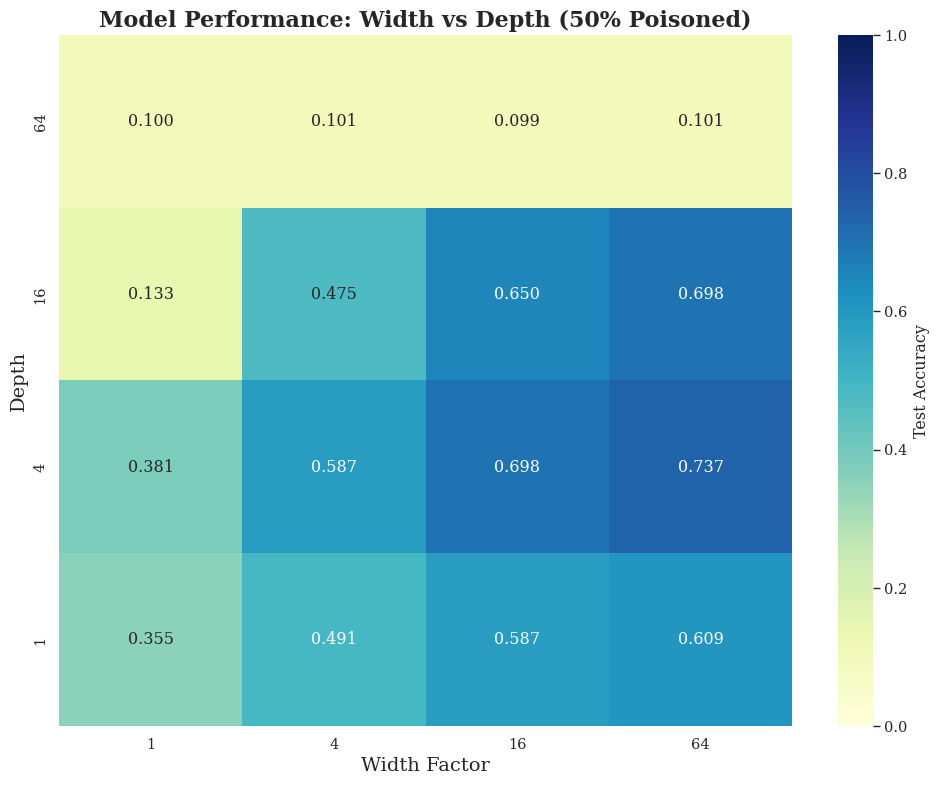

In [25]:
# Filter poisoned data
poisoned_data = df[df['poison_ratio'] == 0.5].copy()

# Create pivot table
pivot_poisoned = poisoned_data.pivot_table(
    values='mean_test_acc', 
    index='depth', 
    columns='width_factor',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_poisoned, annot=True, fmt='.3f', cmap='YlGnBu', 
            cbar_kws={'label': 'Test Accuracy'}, vmin=0.0, vmax=1.0)
plt.title('Model Performance: Width vs Depth (50% Poisoned)', fontsize=16, weight='bold')
plt.xlabel('Width Factor', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/heatmap_width_vs_depth_poisoned.png")
plt.show()

### 4.3 Line Plot: Fixed Width, Varying Depth

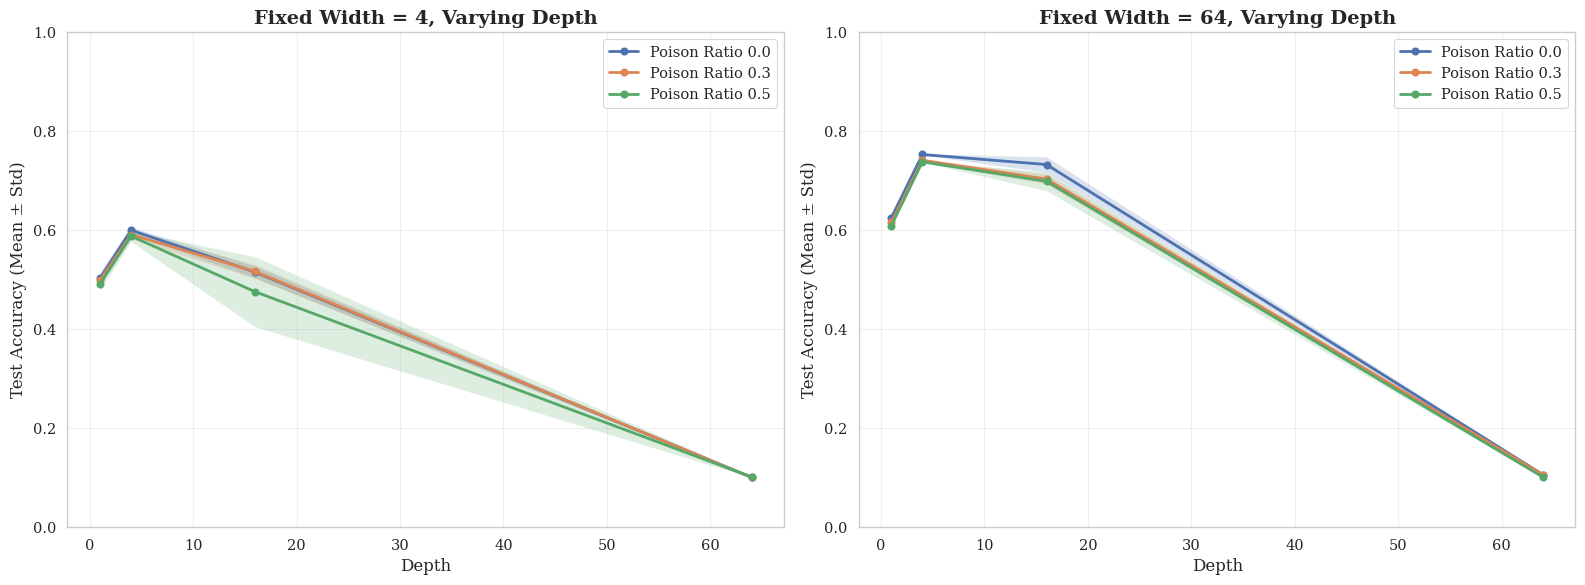

In [ ]:
# Plot for different poison ratios
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fixed width = 4
width_4_data = df[df['width_factor'] == 4]
for pr in sorted(width_4_data['poison_ratio'].unique()):
    subset = width_4_data[width_4_data['poison_ratio'] == pr]
    subset_sorted = subset.sort_values('depth')
    axes[0].plot(subset_sorted['depth'], subset_sorted['mean_test_acc'], 
                 marker='o', label=f'Poison Ratio {pr}', linewidth=2)
    axes[0].fill_between(
        subset_sorted['depth'],
        subset_sorted['mean_test_acc'] - subset_sorted['std_test_acc'],
        subset_sorted['mean_test_acc'] + subset_sorted['std_test_acc'],
        alpha=0.2
    )

axes[0].set_xlabel('Depth', fontsize=12)
axes[0].set_ylabel('Test Accuracy (Mean ± Std)', fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].set_title('Fixed Width = 4, Varying Depth', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Fixed width = 64
width_64_data = df[df['width_factor'] == 64]
for pr in sorted(width_64_data['poison_ratio'].unique()):
    subset = width_64_data[width_64_data['poison_ratio'] == pr]
    subset_sorted = subset.sort_values('depth')
    axes[1].plot(subset_sorted['depth'], subset_sorted['mean_test_acc'], 
                 marker='o', label=f'Poison Ratio {pr}', linewidth=2)
    axes[1].fill_between(
        subset_sorted['depth'],
        subset_sorted['mean_test_acc'] - subset_sorted['std_test_acc'],
        subset_sorted['mean_test_acc'] + subset_sorted['std_test_acc'],
        alpha=0.2
    )

axes[1].set_xlabel('Depth', fontsize=12)
axes[1].set_ylabel('Test Accuracy (Mean ± Std)', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].set_title('Fixed Width = 64, Varying Depth', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/line_fixed_width_varying_depth.png")
plt.show()

### 4.4 Line Plot: Fixed Depth, Varying Width

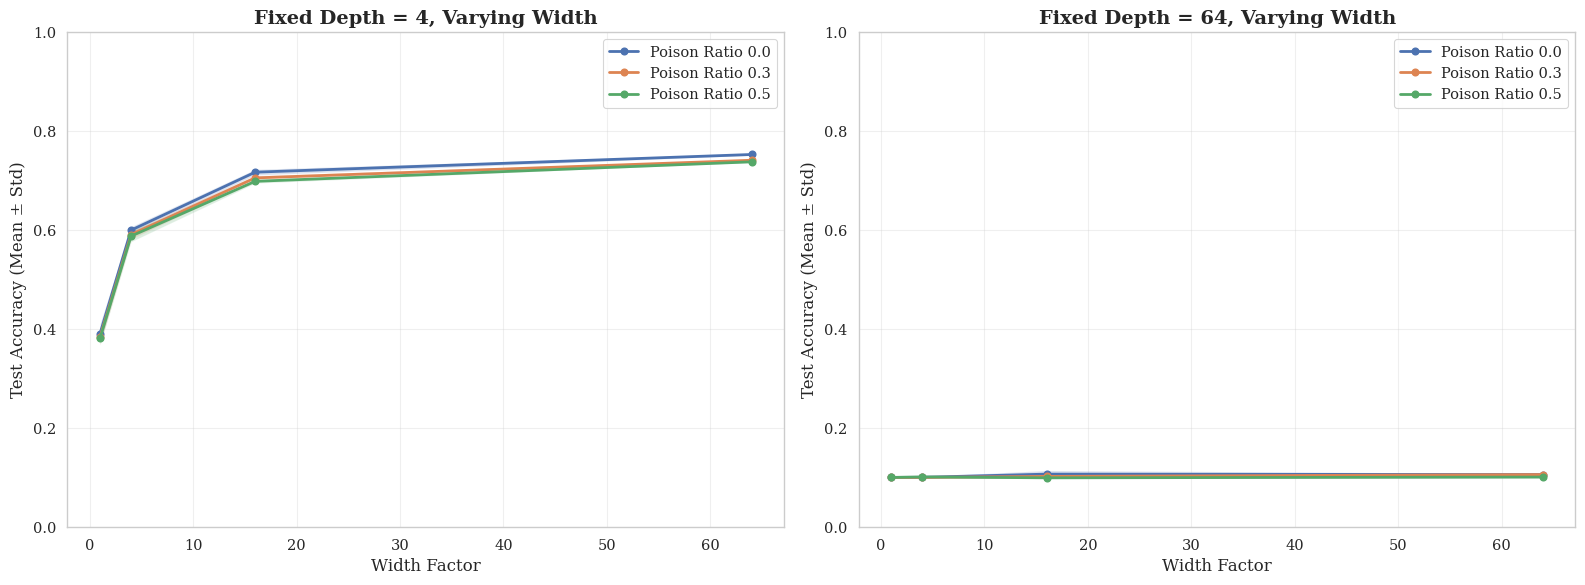

In [19]:
# Plot for different poison ratios
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Fixed depth = 4
depth_4_data = df[df['depth'] == 4]
for pr in sorted(depth_4_data['poison_ratio'].unique()):
    subset = depth_4_data[depth_4_data['poison_ratio'] == pr]
    subset_sorted = subset.sort_values('width_factor')
    axes[0].plot(subset_sorted['width_factor'], subset_sorted['mean_test_acc'], 
                 marker='o', label=f'Poison Ratio {pr}', linewidth=2)
    axes[0].fill_between(
        subset_sorted['width_factor'],
        subset_sorted['mean_test_acc'] - subset_sorted['std_test_acc'],
        subset_sorted['mean_test_acc'] + subset_sorted['std_test_acc'],
        alpha=0.2
    )

axes[0].set_xlabel('Width Factor', fontsize=12)
axes[0].set_ylabel('Test Accuracy (Mean ± Std)', fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].set_title('Fixed Depth = 4, Varying Width', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Fixed depth = 64
depth_64_data = df[df['depth'] == 64]
for pr in sorted(depth_64_data['poison_ratio'].unique()):
    subset = depth_64_data[depth_64_data['poison_ratio'] == pr]
    subset_sorted = subset.sort_values('width_factor')
    axes[1].plot(subset_sorted['width_factor'], subset_sorted['mean_test_acc'], 
                 marker='o', label=f'Poison Ratio {pr}', linewidth=2)
    axes[1].fill_between(
        subset_sorted['width_factor'],
        subset_sorted['mean_test_acc'] - subset_sorted['std_test_acc'],
        subset_sorted['mean_test_acc'] + subset_sorted['std_test_acc'],
        alpha=0.2
    )

axes[1].set_xlabel('Width Factor', fontsize=12)
axes[1].set_ylabel('Test Accuracy (Mean ± Std)', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].set_title('Fixed Depth = 64, Varying Width', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/line_fixed_depth_varying_width.png")
plt.show()

### 4.5 Robustness Heatmap (Clean - Poisoned)

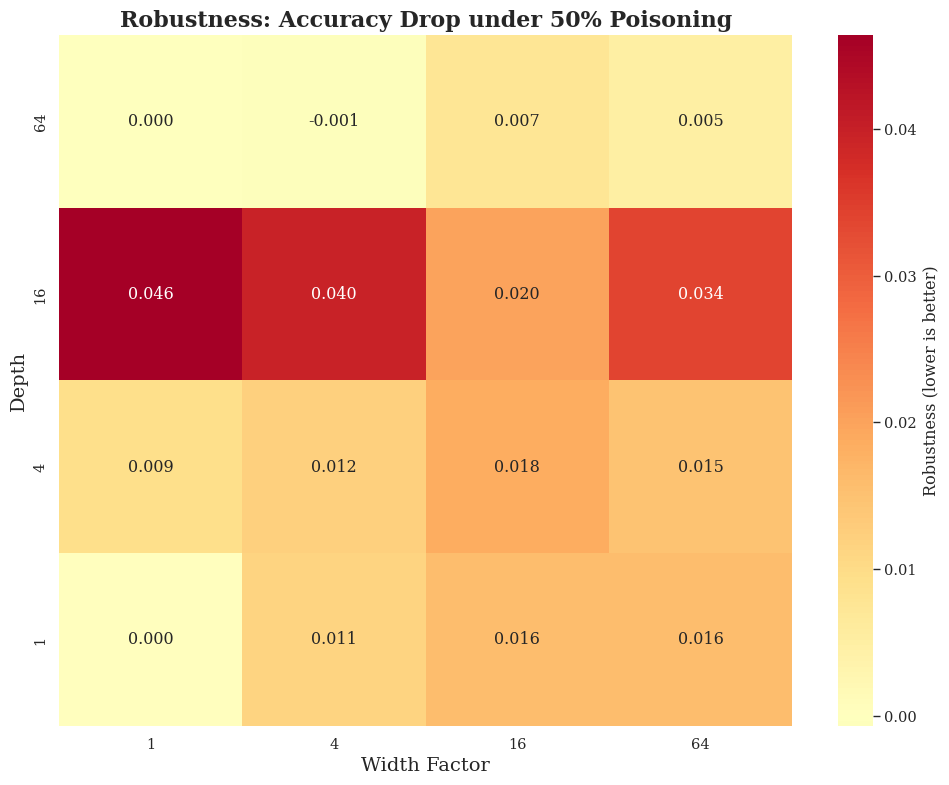

In [26]:
# Calculate robustness: difference between clean and poisoned accuracy
robustness_data = []

for width in df['width_factor'].unique():
    for depth in df['depth'].unique():
        clean_acc = df[(df['width_factor'] == width) & 
                       (df['depth'] == depth) & 
                       (df['poison_ratio'] == 0.0)]['mean_test_acc'].values
        poisoned_acc = df[(df['width_factor'] == width) & 
                          (df['depth'] == depth) & 
                          (df['poison_ratio'] == 0.5)]['mean_test_acc'].values
        
        if len(clean_acc) > 0 and len(poisoned_acc) > 0:
            robustness = clean_acc[0] - poisoned_acc[0]
            robustness_data.append({
                'width_factor': width,
                'depth': depth,
                'robustness': robustness
            })

robustness_df = pd.DataFrame(robustness_data)
pivot_robustness = robustness_df.pivot_table(
    values='robustness',
    index='depth',
    columns='width_factor',
    aggfunc='mean'
)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_robustness, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Robustness (lower is better)'}, center=0)
plt.title('Robustness: Accuracy Drop under 50% Poisoning', fontsize=16, weight='bold')
plt.xlabel('Width Factor', fontsize=14)
plt.ylabel('Depth', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/heatmap_robustness.png")
plt.show()

## 5. General Observations

### Key Findings:

1. **Width vs Depth Trade-off**
   - Based on the heatmaps, we can observe which dimension (width or depth) provides better baseline performance
   - The clean data heatmap shows the best configurations for standard federated learning

2. **Robustness Patterns**
   - The robustness heatmap reveals which architectural choices maintain performance under attack
   - Lower robustness values (smaller accuracy drops) indicate better defense against poisoning

3. **Scaling Efficiency**
   - Line plots show how accuracy changes as we scale each dimension independently
   - Diminishing returns may be visible at extreme width or depth values

4. **Attack Sensitivity**
   - Configurations with large performance drops between clean and poisoned scenarios are more vulnerable
   - More robust configurations maintain higher accuracy even under 50% poisoning

## 6. Mathematical Analysis

### 6.1 Robustness Metric

We define robustness $R$ as the accuracy degradation under poisoning:

$$
R(w, d) = \text{Acc}_{\text{clean}}(w, d) - \text{Acc}_{\text{poisoned}}(w, d)
$$

where $w$ is width factor, $d$ is depth, and lower $R$ indicates better robustness.

In [11]:
# Calculate robustness statistics
print("Robustness Statistics (Accuracy Drop under 50% Poisoning):")
print(f"Mean: {robustness_df['robustness'].mean():.4f}")
print(f"Std: {robustness_df['robustness'].std():.4f}")
print(f"Min (Most Robust): {robustness_df['robustness'].min():.4f}")
print(f"Max (Least Robust): {robustness_df['robustness'].max():.4f}")

# Find most robust configuration
most_robust = robustness_df.loc[robustness_df['robustness'].idxmin()]
print(f"\nMost Robust Configuration:")
print(f"  Width: {most_robust['width_factor']}, Depth: {most_robust['depth']}")
print(f"  Robustness: {most_robust['robustness']:.4f}")

Robustness Statistics (Accuracy Drop under 50% Poisoning):
Mean: 0.0157
Std: 0.0139
Min (Most Robust): -0.0007
Max (Least Robust): 0.0464

Most Robust Configuration:
  Width: 4.0, Depth: 64.0
  Robustness: -0.0007


### 6.2 Model Capacity Analysis

The approximate parameter count for a CNN scales as:

$$
\text{Params}(w, d) \approx w^2 \cdot d \cdot c
$$

where $c$ is a constant depending on input dimensions and output classes.

### 6.3 Statistical Significance Testing

In [12]:
# Compare width scaling vs depth scaling (at moderate poisoning)
moderate_poison = df[df['poison_ratio'] == 0.3].copy()

# Width scaling (fixed depth = 4)
width_scaling = moderate_poison[moderate_poison['depth'] == 4]['mean_test_acc'].values

# Depth scaling (fixed width = 4)
depth_scaling = moderate_poison[moderate_poison['width_factor'] == 4]['mean_test_acc'].values

if len(width_scaling) > 0 and len(depth_scaling) > 0:
    t_stat, p_value = stats.ttest_ind(width_scaling, depth_scaling)
    print("\nT-test: Width Scaling vs Depth Scaling (30% Poisoning)")
    print(f"  Width Scaling Mean: {width_scaling.mean():.4f}")
    print(f"  Depth Scaling Mean: {depth_scaling.mean():.4f}")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("  ✓ Statistically significant difference (p < 0.05)")
    else:
        print("  ✗ No statistically significant difference (p >= 0.05)")


T-test: Width Scaling vs Depth Scaling (30% Poisoning)
  Width Scaling Mean: 0.6051
  Depth Scaling Mean: 0.4263
  t-statistic: 1.3078
  p-value: 0.2388
  ✗ No statistically significant difference (p >= 0.05)


### 6.4 Effect Size (Cohen's d)

Cohen's d measures the standardized difference between two means:

$$
d = \frac{\mu_1 - \mu_2}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}
$$

Interpretation: |d| < 0.2 (small), 0.2-0.8 (medium), > 0.8 (large)

In [13]:
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

if len(width_scaling) > 0 and len(depth_scaling) > 0:
    effect_size = cohens_d(width_scaling, depth_scaling)
    print(f"\nCohen's d: {effect_size:.4f}")
    
    if abs(effect_size) < 0.2:
        effect = "small"
    elif abs(effect_size) < 0.8:
        effect = "medium"
    else:
        effect = "large"
    
    print(f"Effect size: {effect}")


Cohen's d: 0.9248
Effect size: large


## 7. Conclusions

### Key Takeaways:

1. **Architectural Impact on Robustness**
   - The experiment reveals how width and depth independently affect model robustness
   - The most robust configuration provides guidance for model architecture selection

2. **Width vs Depth Trade-off**
   - Statistical tests quantify whether width or depth provides better defense
   - Effect sizes indicate the practical significance of architectural choices

3. **Practical Implications**
   - For deployed federated learning systems under poisoning threats, use configurations with minimal robustness metric
   - Consider parameter efficiency: achieve good robustness with fewer parameters

4. **Future Work**
   - Investigate optimal width-to-depth ratios more systematically
   - Test on more complex datasets (CIFAR-10, ImageNet)
   - Combine architectural robustness with defensive aggregation methods

---

**Next Steps**: See Experiment 1 for fine-grained width analysis and double descent phenomena.